# Transformer model for language understanding

FYP: Machine translation models for Cantonese­English pair

In [1]:
!pip install -q tfds-nightly

# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
!pip install -q matplotlib==3.2.2
# Chinese font in matplotlib
from matplotlib.font_manager import FontProperties
!pip install -q wget
import wget
# !wget -qO taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
# !mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.6/dist-packages/matplotlib//mpl-data/fonts/ttf
# chinese = FontProperties(fname=r'/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')
wget.download('https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download', 'taipei_sans_tc_beta.ttf')
!move taipei_sans_tc_beta.ttf c:\users\hey0\anaconda3\lib\site-packages/matplotlib//mpl-data/fonts/ttf
chinese = FontProperties(fname=r'c:\users\hey0\anaconda3\lib\site-packages/matplotlib//mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

!pip install -q tensorflow

-1 / unknown移動         1 個檔案。


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import re
import time
import numpy as np
import matplotlib.pyplot as plt

## Setup input pipeline

In [3]:
import pandas as pd
import glob
import os

all_csv = glob.glob(os.getcwd() + "/Preprocessed_Corpus.csv")  
 
df_from_each_file = (pd.read_csv(f, sep='\t', encoding='utf-8') for f in all_csv)
df = pd.concat(df_from_each_file)

# Check for null
df[df['yue'].isnull()]
df = df.dropna()

YueChar = True
# Delete spaces between n-gram in Cantonese
# Perform Character based tokenization in Cantonese
if YueChar:
    df['yue'] = df['yue'].str.replace(r' ', '')

df.head()

,yue,eng
0,大家好我叫Frank,Hi my name is Frank
1,我收集人哋嘅秘密,and I collect secrets
2,而一切都源於我,It all started with a crazy idea
3,2004年11月一個瘋狂嘅諗法,in November of 2004
4,我當時打印咗三千張,I printed up 3 000 self addressed postcards


### Set translational direction

In [4]:
inp_lang = 'eng'
tar_lang = 'yue'
inp = df[inp_lang]
tar = df[tar_lang]
dataset = tf.data.Dataset.from_tensor_slices((inp.values, tar.values))

## Split dataset into train, test and validation

In [5]:
DATASET_SIZE = len(list(dataset))
train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

dataset = dataset.shuffle(DATASET_SIZE)
train_examples = dataset.take(train_size)
test_examples = dataset.skip(train_size)
# test_examples = remaining.take(test_size)
# val_examples = remaining.skip(test_size)

print('Train size:', len(list(train_examples)))
print('Test size:', len(list(test_examples)))
# print('Validation size:', len(list(val_examples)))
print()
print('Total size:', DATASET_SIZE)

Train size: 7848
Test size: 1963

Total size: 9811


In [6]:
for inp, tar in train_examples.take(3):
  print(inp)
  print(tar)
  print('-' * 10)

tf.Tensor(b'a few hundred quid Dan', shape=(), dtype=string)
tf.Tensor(b'\xe6\x88\x91\xe5\x93\x8b\xe6\x9c\x83\xe6\x90\x8d\xe5\xa4\xb1\xe5\xb9\xbe\xe7\x99\xbe\xe8\x8b\xb1\xe7\xa3\x85Dan', shape=(), dtype=string)
----------
tf.Tensor(b'Even the idea of us as a family', shape=(), dtype=string)
tf.Tensor(b'\xe5\x8d\xb3\xe4\xbd\xbf\xe4\xbd\x9c\xe7\x82\xba\xe4\xb8\x80\xe5\x80\x8b\xe5\x92\x81\xe6\xa8\xa3\xe5\x98\x85\xe5\xae\xb6\xe5\xba\xad', shape=(), dtype=string)
----------
tf.Tensor(b'Will Dad stop the wedding', shape=(), dtype=string)
tf.Tensor(b'\xe4\xbd\xa0\xe9\xa9\x9a\xe6\x88\x91\xe8\xbf\x94\xe5\x9a\x9f\xe6\x90\x9e\xe7\xa0\xb4\xe5\xa3\x9e', shape=(), dtype=string)
----------


In [7]:
sample_examples = []
num_samples = 5

for inp_t, tar_t in train_examples.take(num_samples):
  inp = inp_t.numpy().decode("utf-8")
  tar = tar_t.numpy().decode("utf-8")
  
  print(inp)
  print(tar)
  print('-' * 10)
  
  sample_examples.append((inp, tar))

So we have this thick uterine lining and now it s got to come out and how do you stop bleeding Well you stop a nose bleed by pinching it if you cut your leg you put pressure on it We stop bleeding with pressure When we menstruate the lining of the uterus releases substances that are made into chemicals called prostaglandins and other inflammatory mediators And they make the uterus cramp down they make it squeeze on those blood vessels to stop the bleeding They might also change blood flow to the uterus and also cause inflammation and that makes pain worse
因此形成厚嘅子宮厚內膜同埋佢點可以脫落咁你點樣止血呢止鼻血你會捻住個鼻如果隻腳整損咗你會壓住個傷口用壓力去阻止出血當我哋嚟經期子宮內膜會釋放出一種物質叫做前列腺素嘅化學物質同其他發炎症介質佢哋會令到子宮抽筋佢哋會擠壓血管止血改變咗子宮嘅血流狀況會引起發炎加劇咗啲痛楚
----------
from the ground up
重新設計
----------
You know I can t see colors
睇唔到㗎喇
----------
Okay Now this is the major change that I ve seen how teaching English has morphed from being a mutually beneficial practice to becoming a massive international business that it is today No longer just a foreign la

Create a custom subwords tokenizer from the training dataset. 

In [8]:
if inp_lang == 'yue':
    if YueChar:
      input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
          (inp.numpy() for inp, tar in train_examples), target_vocab_size=2**13, max_subword_length=1)
    else:
      input_tokenizer = tfds.deprecated.text.TokenTextEncoder(
          ' '.join(inp.numpy().decode("utf-8") for inp, tar in train_examples).split(' ')) 
    target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        (tar.numpy() for inp, tar in train_examples), target_vocab_size=2**13)
else:
    if YueChar:
      target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
          (tar.numpy() for inp, tar in train_examples), target_vocab_size=2**13, max_subword_length=1)
    else:
      target_tokenizer = tfds.deprecated.text.TokenTextEncoder(
          ' '.join(tar.numpy().decode("utf-8") for inp, tar in train_examples).split(' '))
    input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (inp.numpy() for inp, tar in train_examples), target_vocab_size=2**13)

Check the tokenizers with sample string

In [9]:
# We can use string in dataset
sample_inp = sample_examples[0][0]
sample_tar = sample_examples[0][1]

tokenized_inp = input_tokenizer.encode(sample_inp)
print ('Tokenized string is {}'.format(tokenized_inp))

original_inp = input_tokenizer.decode(tokenized_inp)
print ('The original string: {}'.format(original_inp))

tokenized_tar = target_tokenizer.encode(sample_tar)
print ('Tokenized string is {}'.format(tokenized_tar))

original_tar = target_tokenizer.decode(tokenized_tar)
print ('The original string: {}'.format(original_tar))

Tokenized string is [25, 13, 19, 16, 3414, 3375, 5844, 77, 1954, 3, 128, 11, 7, 141, 2, 167, 70, 3, 74, 41, 10, 367, 5156, 176, 10, 367, 5, 3644, 670, 49, 52, 1923, 1505, 171, 11, 60, 10, 783, 58, 4697, 10, 193, 1314, 21, 11, 53, 367, 5156, 22, 1314, 161, 13, 4647, 77, 1, 1954, 4, 1, 1695, 3537, 5193, 7, 5680, 7, 8, 20, 172, 92, 5104, 175, 5959, 4035, 1069, 3025, 3, 94, 6433, 6261, 359, 1756, 5596, 14, 23, 106, 1, 1695, 6910, 401, 142, 23, 106, 11, 7676, 5937, 1534, 21, 114, 407, 3370, 2, 367, 1, 5156, 91, 228, 116, 194, 407, 1795, 2, 1, 1695, 3, 116, 786, 6433, 6262, 3, 8, 476, 735, 2377]
The original string: So we have this thick uterine lining and now it s got to come out and how do you stop bleeding Well you stop a nose bleed by pinching it if you cut your leg you put pressure on it We stop bleeding with pressure When we menstruate the lining of the uterus releases substances that are made into chemicals called prostaglandins and other inflammatory mediators And they make the uteru

The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [10]:
for ts in tokenized_inp:
  print ('{} ----> {}'.format(ts, input_tokenizer.decode([ts])))
print()
for ts in tokenized_tar:
  print ('{} ----> {}'.format(ts, target_tokenizer.decode([ts])))

25 ----> So 
13 ----> we 
19 ----> have 
16 ----> this 
3414 ----> thick 
3375 ----> ute
5844 ----> rin
77 ----> e 
1954 ----> lining 
3 ----> and 
128 ----> now 
11 ----> it 
7 ----> s 
141 ----> got 
2 ----> to 
167 ----> come 
70 ----> out 
3 ----> and 
74 ----> how 
41 ----> do 
10 ----> you 
367 ----> stop 
5156 ----> bleeding 
176 ----> Well 
10 ----> you 
367 ----> stop 
5 ----> a 
3644 ----> nose 
670 ----> ble
49 ----> ed 
52 ----> by 
1923 ----> pin
1505 ----> chi
171 ----> ng 
11 ----> it 
60 ----> if 
10 ----> you 
783 ----> cut 
58 ----> your 
4697 ----> leg 
10 ----> you 
193 ----> put 
1314 ----> pressure 
21 ----> on 
11 ----> it 
53 ----> We 
367 ----> stop 
5156 ----> bleeding 
22 ----> with 
1314 ----> pressure 
161 ----> When 
13 ----> we 
4647 ----> menstruat
77 ----> e 
1 ----> the 
1954 ----> lining 
4 ----> of 
1 ----> the 
1695 ----> uterus 
3537 ----> rele
5193 ----> ase
7 ----> s 
5680 ----> substance
7 ----> s 
8 ----> that 
20 ----> are 
172 ----> made 
92 

In [11]:
BUFFER_SIZE = 400
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [12]:
def encode(lang1, lang2):
  lang1 = [input_tokenizer.vocab_size] + input_tokenizer.encode(
      lang1.numpy()) + [input_tokenizer.vocab_size+1]

  lang2 = [target_tokenizer.vocab_size] + target_tokenizer.encode(
      lang2.numpy()) + [target_tokenizer.vocab_size+1]
  
  return lang1, lang2

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [13]:
def tf_encode(inp, tar):
  result_inp, result_tar = tf.py_function(encode, [inp, tar], [tf.int64, tf.int64])
  result_inp.set_shape([None])
  result_tar.set_shape([None])

  return result_inp, result_tar

Note: To keep this example small and relatively fast, drop examples with a length of over 100 tokens.

In [14]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [15]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
num_examples = 0
for inp_indices, tar_indices in train_dataset:
  num_examples += 1
print(f"Training size: {num_examples}")

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Training size: 6820


In [16]:
# Check with train set
inp_indices, tar_indices  = next(iter(train_dataset))
print(inp_indices)
print(tar_indices)

num_examples = 0
for inp_indices, tar_indices in train_dataset:
  # cond1 = len(inp_indices) <= MAX_LENGTH
  # cond2 = len(tar_indices) <= MAX_LENGTH
  # assert cond1 and cond2
  num_examples += 1

print(f"\nAll string are less than {MAX_LENGTH} tokens")
print(f"Total batches: {num_examples}")

tf.Tensor(
[[7817    8   73 ...    0    0    0]
 [7817  161    1 ...    0    0    0]
 [7817    6   65 ...    0    0    0]
 ...
 [7817   35  426 ...    0    0    0]
 [7817  411  123 ...    0    0    0]
 [7817   55  640 ...    0    0    0]], shape=(64, 17), dtype=int64)
tf.Tensor(
[[3369   20   15 ...    0    0    0]
 [3369   61  356 ...    0    0    0]
 [3369    2   57 ...    0    0    0]
 ...
 [3369   14    3 ...    0    0    0]
 [3369   45   93 ...    0    0    0]
 [3369    7    5 ...    0    0    0]], shape=(64, 27), dtype=int64)

All string are less than 40 tokens
Total batches: 107


## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [17]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


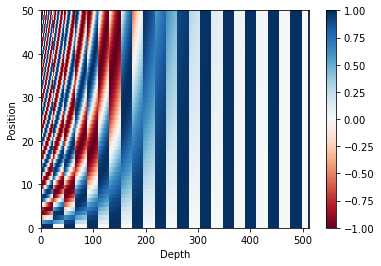

In [19]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [20]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [21]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [22]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [23]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [25]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [26]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [27]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [28]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [29]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [31]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [32]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [33]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [35]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [37]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [38]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [39]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [41]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [42]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [43]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [44]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = input_tokenizer.vocab_size + 2
target_vocab_size = target_tokenizer.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [46]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

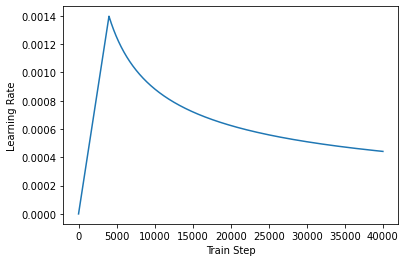

In [47]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [48]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [49]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [51]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [52]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [53]:
checkpoint_path = "./checkpoints" + f"/{100}EPOCHS_{YueChar}YueChar"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [54]:
EPOCHS = 100

In [55]:
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{EPOCHS}EPOCHS_{YueChar}YueChar"
log_dir = os.path.join(os.path.join(os.getcwd(), 'log'), run_id)
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

In [56]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [57]:
summary_writer = tf.summary.create_file_writer(log_dir)
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # Save output to TensorBoard
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.1309 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.0512 Accuracy 0.0175
Epoch 1 Batch 100 Loss 7.9284 Accuracy 0.0269
Epoch 1 Loss 7.9143 Accuracy 0.0274
Time taken for 1 epoch: 86.73917984962463 secs

Epoch 2 Batch 0 Loss 7.6087 Accuracy 0.0435
Epoch 2 Batch 50 Loss 7.5283 Accuracy 0.0374
Epoch 2 Batch 100 Loss 7.3746 Accuracy 0.0370
Epoch 2 Loss 7.3558 Accuracy 0.0368
Time taken for 1 epoch: 72.33214902877808 secs

Epoch 3 Batch 0 Loss 6.9573 Accuracy 0.0476
Epoch 3 Batch 50 Loss 6.8113 Accuracy 0.0379
Epoch 3 Batch 100 Loss 6.6470 Accuracy 0.0365
Epoch 3 Loss 6.6279 Accuracy 0.0365
Time taken for 1 epoch: 80.71447396278381 secs

Epoch 4 Batch 0 Loss 6.3208 Accuracy 0.0357
Epoch 4 Batch 50 Loss 6.1964 Accuracy 0.0387
Epoch 4 Batch 100 Loss 6.1297 Accuracy 0.0405
Epoch 4 Loss 6.1219 Accuracy 0.0410
Time taken for 1 epoch: 89.35269737243652 secs

Epoch 5 Batch 0 Loss 5.9798 Accuracy 0.0474
Epoch 5 Batch 50 Loss 5.9674 Accuracy 0.0484
Epoch 5 Batch 100 Loss 5.9422 Accur

Epoch 36 Batch 0 Loss 1.7318 Accuracy 0.2704
Epoch 36 Batch 50 Loss 1.5838 Accuracy 0.2432
Epoch 36 Batch 100 Loss 1.5606 Accuracy 0.2384
Epoch 36 Loss 1.5570 Accuracy 0.2398
Time taken for 1 epoch: 63.82232403755188 secs

Epoch 37 Batch 0 Loss 1.5337 Accuracy 0.3132
Epoch 37 Batch 50 Loss 1.5252 Accuracy 0.2524
Epoch 37 Batch 100 Loss 1.4940 Accuracy 0.2474
Epoch 37 Loss 1.4876 Accuracy 0.2483
Time taken for 1 epoch: 62.820218563079834 secs

Epoch 38 Batch 0 Loss 1.4625 Accuracy 0.2704
Epoch 38 Batch 50 Loss 1.4653 Accuracy 0.2592
Epoch 38 Batch 100 Loss 1.4370 Accuracy 0.2500
Epoch 38 Loss 1.4327 Accuracy 0.2518
Time taken for 1 epoch: 63.247493743896484 secs

Epoch 39 Batch 0 Loss 1.5001 Accuracy 0.2554
Epoch 39 Batch 50 Loss 1.3933 Accuracy 0.2581
Epoch 39 Batch 100 Loss 1.3633 Accuracy 0.2555
Epoch 39 Loss 1.3577 Accuracy 0.2558
Time taken for 1 epoch: 63.92663860321045 secs

Epoch 40 Batch 0 Loss 1.3337 Accuracy 0.2640
Epoch 40 Batch 50 Loss 1.3210 Accuracy 0.2671
Epoch 40 Batch 

Epoch 71 Batch 0 Loss 0.3720 Accuracy 0.3464
Epoch 71 Batch 50 Loss 0.3908 Accuracy 0.3565
Epoch 71 Batch 100 Loss 0.3908 Accuracy 0.3444
Epoch 71 Loss 0.3909 Accuracy 0.3472
Time taken for 1 epoch: 61.61254405975342 secs

Epoch 72 Batch 0 Loss 0.4401 Accuracy 0.3432
Epoch 72 Batch 50 Loss 0.3768 Accuracy 0.3601
Epoch 72 Batch 100 Loss 0.3742 Accuracy 0.3532
Epoch 72 Loss 0.3725 Accuracy 0.3542
Time taken for 1 epoch: 60.886255741119385 secs

Epoch 73 Batch 0 Loss 0.4233 Accuracy 0.4158
Epoch 73 Batch 50 Loss 0.3831 Accuracy 0.3607
Epoch 73 Batch 100 Loss 0.3743 Accuracy 0.3542
Epoch 73 Loss 0.3735 Accuracy 0.3530
Time taken for 1 epoch: 60.81855773925781 secs

Epoch 74 Batch 0 Loss 0.3409 Accuracy 0.3488
Epoch 74 Batch 50 Loss 0.3583 Accuracy 0.3558
Epoch 74 Batch 100 Loss 0.3581 Accuracy 0.3516
Epoch 74 Loss 0.3571 Accuracy 0.3525
Time taken for 1 epoch: 61.35580348968506 secs

Epoch 75 Batch 0 Loss 0.3698 Accuracy 0.3357
Epoch 75 Batch 50 Loss 0.3654 Accuracy 0.3624
Epoch 75 Batch 1

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`input_tokenizer`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == target_tokenizer.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [58]:
def evaluate(inp_sentence):
  start_token = [input_tokenizer.vocab_size]
  end_token = [input_tokenizer.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + input_tokenizer.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [target_tokenizer.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == target_tokenizer.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [59]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = input_tokenizer.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    # show Chinese character
    fontdict = {"fontproperties": chinese}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[input_tokenizer.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([target_tokenizer.decode([i]) for i in result 
                        if i < target_tokenizer.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [60]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = target_tokenizer.decode([i for i in result 
                                            if i < target_tokenizer.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

So for the last five years as a professor of business and psychology I ve been studying the effect of screens on our lives And I want to start by just focusing on how much time they take from us and then we can talk about what that time looks like What I m showing you here is the average 24 hour workday at three different points in history 2007 10 years ago 2015 and then data that I collected actually only last week And a lot of things haven t changed all that much We sleep roughly seven and a half to eight hours a day some people say that s declined slightly but it hasn t changed much We work eight and a half to nine hours a day We engage in survival activities these are things like eating and bathing and looking after kids about three hours a day
所以喺過去五年間作為一名商業同心理學教授我一直喺度研究觸屏產品對我哋生活嘅影響我先計下佢哋消耗咗我哋幾多時間然後再討論我哋用呢段時間做咗咩我哋就揀一個平常嘅工作日按佢有24小時噉計我哋搵咗三個嘅時間點2007年即係10年前2015年同我上個星期啱收集咗數據嘅2017年好多嘢都冇點變我哋仲係每日瞓大概7個半到8個鐘有人話睡眠時間輕微減少咗但實際冇好大變化我哋每日做8個半到9個鐘嘅工仲有啲日常活動譬如食飯沖涼湊細路仔每日要花費三個鐘 

Input: So for the last

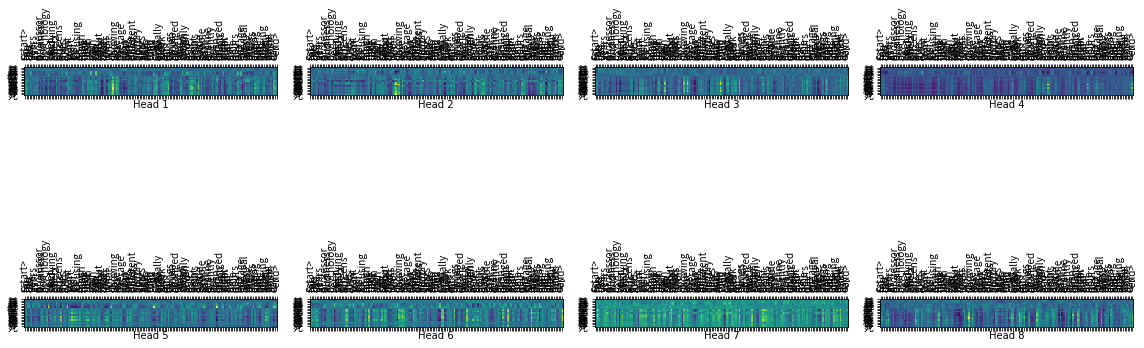

In [61]:
import random
ran = random.randint(1, len(test_examples))

for inp_t, tar_t in test_examples.take(ran):
  inp = inp_t.numpy().decode("utf-8")
  tar = tar_t.numpy().decode("utf-8")
print(inp)
print(tar, '\n')

translate(inp, plot='decoder_layer4_block2')

In [62]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1793920   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  1489792   
_________________________________________________________________
dense_151 (Dense)            multiple                  434859    
Total params: 3,718,571
Trainable params: 3,718,571
Non-trainable params: 0
_________________________________________________________________


In [63]:
def translateTest(sentence):
  result, attention_weights = evaluate(sentence)
  
  sentence = input_tokenizer.encode(sentence)
  sentence = ' '.join([input_tokenizer.decode([i]) for i in sentence])
  predicted_sentence = target_tokenizer.decode([i for i in result 
                                            if i < target_tokenizer.vocab_size])  

#   print('Input: {}'.format(sentence))
#   print('Predicted translation: {}'.format(predicted_sentence))
  return sentence, predicted_sentence

In [64]:
ref = []
can = []
num_test = 0
TotalTime = time.time()
start = time.time()
for inp_t, tar_t in test_examples:
    inp = inp_t.numpy().decode("utf-8")
    tar = tar_t.numpy().decode("utf-8")
    num_test += 1
    if len(inp.split()) < 40 and len(tar.split()) < 40:
        inp_r, pre = translateTest(inp)
        ref.append([tar.split()])
        can.append(pre.split())
    if num_test % 50 == 0:
        print(f'Progress: {num_test} / {len(test_examples)} in {time.time()-start} s')
        start = time.time()
        
print(f'ToTal: {num_test} / {len(test_examples)} in {time.time()-TotalTime}')

Progress: 50 / 1963 in 37.122886180877686 s
Progress: 100 / 1963 in 38.52077674865723 s
Progress: 150 / 1963 in 39.02763056755066 s
Progress: 200 / 1963 in 34.362820625305176 s
Progress: 250 / 1963 in 32.58601951599121 s
Progress: 300 / 1963 in 35.41471719741821 s
Progress: 350 / 1963 in 32.751158475875854 s
Progress: 400 / 1963 in 31.665842533111572 s
Progress: 450 / 1963 in 35.866628646850586 s
Progress: 500 / 1963 in 33.88088583946228 s
Progress: 550 / 1963 in 36.2839674949646 s
Progress: 600 / 1963 in 31.997430562973022 s
Progress: 650 / 1963 in 39.68129253387451 s
Progress: 700 / 1963 in 38.3552405834198 s
Progress: 750 / 1963 in 29.984587907791138 s
Progress: 800 / 1963 in 34.030314922332764 s
Progress: 850 / 1963 in 29.737730741500854 s
Progress: 900 / 1963 in 33.78821849822998 s
Progress: 950 / 1963 in 33.87883186340332 s
Progress: 1000 / 1963 in 36.80983901023865 s
Progress: 1050 / 1963 in 34.49716758728027 s
Progress: 1100 / 1963 in 35.77988243103027 s
Progress: 1150 / 1963 i

In [68]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

score = 0
for i in range(len(ref)):
    score += sentence_bleu(ref[i], can[i], weights=(1, 0, 0, 0))
print('BLEU test result:', score/len(ref)*100)

BLEU test result: 71.52122641509435
